In [1]:
import math
import numpy as np
from astropy.io.votable import parse_single_table
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import glob
from scipy import stats

import seaborn as sns
import pandas as pd
sns.set()

## Catalogue statistics and plots

Calculate statistics based on the spectra catalogue.

### Table of Contents

* [Noise Statistics](#Noise-Statistics)
* [CDF of detections and non-detections](#CDF-of-detections-and-non-detections)
* [Filter absorption in noisy spectra which were later excluded](#Filter-absorption-in-noisy-spectra-which-were-later-excluded)
* [Plot of SMC absorption features by optical depth](#Plot-of-SMC-absorption-features-by-optical-depth)
* [Comparison of detections with noise and flux](#Comparison-of-detections-with-noise-and-flux)


### Noise Statistics


In [2]:
#spec_tab = parse_single_table('sb10944/v3a/askap_spectra.vot').to_table()
spec_tab = parse_single_table('gaskap_smc_spectra.vot').to_table()

In [3]:
spec_tab

id,comp_name,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,nh_gass,noise_flag,beam_power,nh_uncorr,e_nh_uncorr_high,e_nh_uncorr_low,nh_corr,e_nh_corr_high,e_nh_corr_low,r_hi,e_r_hi_high,e_r_hi_low,f_int,mean_ts,e_mean_ts_high,e_mean_ts_low,ew,e_ew_high,e_ew_low,num_chan
,,deg,deg,,,,mJy / beam,,mJy / beam,,,,,,,km / s,,,,,arcsec,arcsec,deg,1 / cm2,,,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,1 / cm2,,,,,,,,km / s,km / s,km / s,
int64,str32,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,bool,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,J004725-712727,11.85596,-71.457707,303.38855682118844,-45.66698499458346,B,15.015000343322754,16.121999740600586,0.0001577413873746991,0.20037295013116518,1.1125783920288086,1.0923846748301125,1.5317274332046509,43.0,0.41914910078048706,96.17224896304,0.869528591632843,0.3925101382105877,False,False,3.82400016784668,3.2720001220703128,133.6300048828125,6.174081421437779e+20,False,1.0359205,5.3694145173696637e+20,2.0103158757534925e+19,2.1511460131229663e+19,6.10077443153079e+20,3.136749487657779e+19,3.1258633262845133e+19,1.1341145793340182,0.03880858092081141,0.02989499073286006,1.1028749527560096,49.30100588798518,16.70411904366845,9.680265776401129,7.7382428975296715,2.2374244948852398,1.6120891413928853,40.0
5,J002620-743741,6.586833,-74.628167,305.17933901817554,-42.39041885268388,C,15.201000213623047,17.952999114990234,0.00014202001038938762,0.26400873561229615,1.9746829271316528,1.4209718128364035,1.815657138824463,67.0,-0.15902580320835114,132.02632915333402,5.0,3.8316940181297285,False,False,4.056000137329102,3.3919998168945313,135.64999389648438,1.3315663738275294e+21,False,0.88999236,1.6655641101834298e+21,4.068341488619199e+19,4.24531421305876e+19,1.9486391136864934e+21,9.423019874349141e+19,8.360980317262027e+19,1.1685198767316813,0.05146251767448029,0.04076326046378176,1.109492945397391,131.91745656277405,76.0394798717538,36.60689727580875,13.045630478583519,4.167122991917667,2.9483040618224354,75.0
9,J011635-712604,19.148794,-71.434582,300.07682214784444,-45.55395103946494,C,15.333000183105469,16.06100082397461,0.0001255630166269839,0.21174872823938362,1.6042497158050537,0.7604905305141251,1.9112515449523926,74.0,0.30700182914733887,185.81443163211898,1.1809015274047852,0.6544683758159434,False,False,3.8040000915527346,3.2080001831054688,142.02000427246094,1.227406986785527e+21,False,1.0161469,9.251622589126413e+20,3.059815273474818e+19,3.1931623875821437e+19,1.0219124975006093e+21,5.6337387168644596e+19,4.681482533212743e+19,1.102877917162054,0.05015471495365387,0.03577941221511938,1.0680958974009322,146.43426889265118,232.0751934359435,66.82200171112265,6.9433111692442235,3.3461228729618053,2.4540143055040535,85.0
10,J010425-742733,16.10635,-74.459193,301.749927250042,-42.63923869702793,C,15.435999870300293,16.30500030517578,0.00011435524793341756,0.2508074329566693,1.681606411933899,0.8255535251261913,1.9211487770080566,78.0,0.2395423799753189,75.45870833663803,1.4290249347686768,0.7164151873632499,False,False,3.7599998474121095,3.2759998321533206,139.1699981689453,3.131320668910356e+20,False,0.95265865,0.0,0.0,0.0,0.0,0.0,0.0,--,--,--,--,--,--,--,0.0,0.0,0.0,0.0
13,J005535-723533,13.899411,-72.592574,302.49551131692516,-44.53215226782472,C,15.053000450134277,31.763999938964844,8.522021817043423e-05,0.16227310227980046,1.856298565864563,2.5452221979121297,1.5236057043075562,93.0,-0.33269286155700684,113.61597766529509,5.0,3.6192534660730047,False,True,5.552000045776367,4.431999969482422,140.7100067138672,7.446596934360939e+21,False,0.9928809,7.168224797796315e+21,7.702330080096263e+19,6.864

In [4]:
min_flux = 0
max_fluxes = [20, 25, 30, 35, 40, 45, 55, 650]
noise_levels = []
for max_flux in max_fluxes:
    subset = (spec_tab['flux_peak'] > min_flux) & (spec_tab['flux_peak'] <= max_flux)
    targets = spec_tab[subset]
    fp_med = np.median(targets['sd_cont'])
    fp_mean = np.mean(targets['sd_cont'])
    min_opacity = 1- (fp_med*3)
    min_tau = 0 if min_opacity < 0 else -1*np.log(min_opacity)
    print ("Flux range {:.0f} to {:.0f} has median {:.4f} and mean {:.4f} 3-sigma opacity {:.3f} tau  {:.3f}  for {} records".format(
        min_flux, max_flux, fp_med, fp_mean, min_opacity, min_tau, len(targets)))
    noise_levels.append(targets['sd_cont'].filled().data)
    min_flux = max_flux

Flux range 0 to 20 has median 0.1680 and mean 0.1679 3-sigma opacity 0.496 tau  0.701  for 66 records
Flux range 20 to 25 has median 0.1435 and mean 0.1450 3-sigma opacity 0.570 tau  0.563  for 44 records
Flux range 25 to 30 has median 0.1170 and mean 0.1176 3-sigma opacity 0.649 tau  0.432  for 24 records
Flux range 30 to 35 has median 0.1054 and mean 0.1054 3-sigma opacity 0.684 tau  0.380  for 22 records
Flux range 35 to 40 has median 0.0932 and mean 0.1005 3-sigma opacity 0.721 tau  0.328  for 9 records
Flux range 40 to 45 has median 0.0818 and mean 0.0755 3-sigma opacity 0.755 tau  0.282  for 10 records
Flux range 45 to 55 has median 0.0579 and mean 0.0610 3-sigma opacity 0.826 tau  0.191  for 9 records
Flux range 55 to 650 has median 0.0370 and mean 0.0370 3-sigma opacity 0.889 tau  0.118  for 45 records


/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [5]:
min_tau_3s = -1*np.log(1- (spec_tab['sd_cont']*3))
min_tau_5s = -1*np.log(1- (spec_tab['sd_cont']*5))

/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_27545/2458286771.py:2: RuntimeWarning: invalid value encountered in log
  min_tau_5s = -1*np.log(1- (spec_tab['sd_cont']*5))


In [6]:
min_tau_3s

0.9190917771249403
1.5703432016268986
1.0085326316425858
1.3960308022839212
0.6671272674459887
1.3717900116137671
1.533902039179903
0.8367069455042913
0.7811593777308482
0.962662570922434
1.0213638985813918


(array([ 3., 11., 10., 12., 13.,  8.,  2.,  4.,  2.,  1.]),
 array([0.01860518, 0.21093943, 0.40327368, 0.59560792, 0.78794217,
        0.98027642, 1.17261066, 1.36494491, 1.55727916, 1.74961341,
        1.94194765]),
 <BarContainer object of 10 artists>)

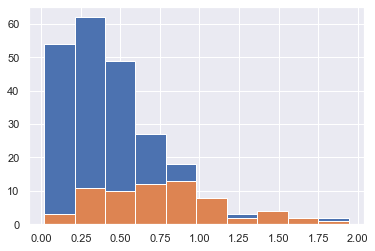

In [7]:
min_flux = 0
max_flux = 20
subset = (spec_tab['flux_peak'] <= max_flux)
values, bins, patches = plt.hist(min_tau_3s)
plt.hist(min_tau_3s[subset], bins=bins)

(array([ 6., 10., 10.,  9.,  1.,  4.,  3.,  1.,  1.,  0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

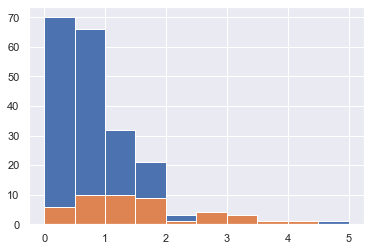

In [8]:
values, bins, patches = plt.hist(min_tau_5s, range=(0,5))
plt.hist(min_tau_5s[subset], bins=bins)

In [9]:
flux_bucket = np.zeros(len(spec_tab), dtype=int)
min_flux = 0
max_fluxes = [20, 25, 30, 40, 50, 650]
bin_size = []
bin_detections = []
bin_label = []

for flux in max_fluxes:
    subset = (spec_tab['flux_peak'] > min_flux) & (spec_tab['flux_peak'] <= flux)
    flux_bucket[subset] = flux
    bin_size.append(np.sum(subset))
    detections = spec_tab[subset]['has_other_abs']
    bin_detections.append(np.sum(detections))
    bin_label.append('>{:.0f}'.format(min_flux) if flux == max_fluxes[-1] else '{:.0f} - {:.0f}'.format(min_flux, flux))

    min_flux = flux

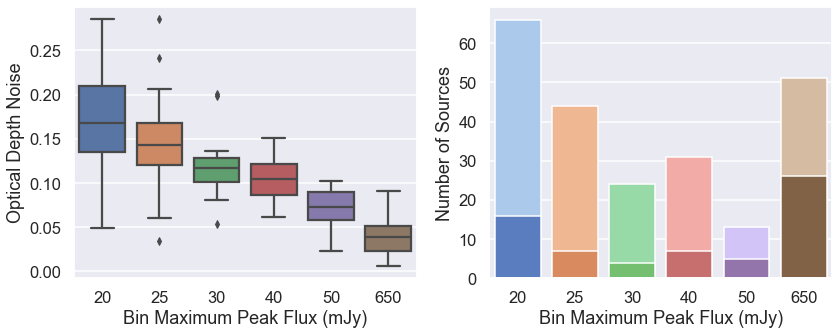

In [10]:
sns.set_context("talk")
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(x=flux_bucket, y=spec_tab['sd_cont'], ax=axes[0])
axes[0].set_xlabel(r'Bin Maximum Peak Flux (mJy)')
axes[0].set_ylabel(r'Optical Depth Noise')

sns.barplot(x=max_fluxes, y=bin_size, ax=axes[1], palette='pastel')
sns.barplot(x=max_fluxes, y=bin_detections, ax=axes[1], palette='muted')
axes[1].set_xlabel(r'Bin Maximum Peak Flux (mJy)')
axes[1].set_ylabel(r'Number of Sources')

fig.set_tight_layout(True)
fig.savefig('figures/noise_by_peak_flux.png')

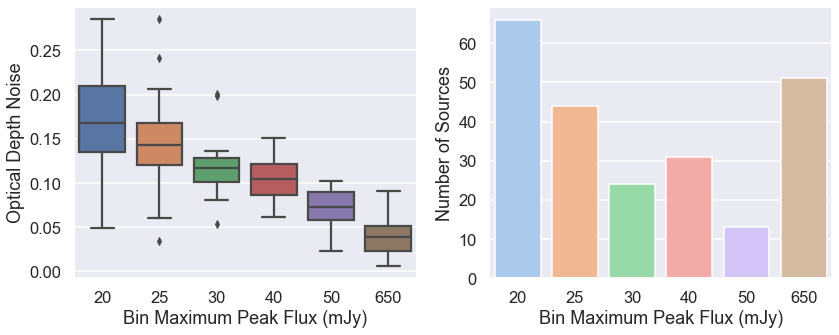

In [11]:
sns.set_context("talk")
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(x=flux_bucket, y=spec_tab['sd_cont'], ax=axes[0])
axes[0].set_xlabel(r'Bin Maximum Peak Flux (mJy)')
axes[0].set_ylabel(r'Optical Depth Noise')

sns.barplot(x=max_fluxes, y=bin_size, ax=axes[1], palette='pastel')
#sns.barplot(x=max_fluxes, y=bin_detections, ax=axes[1], palette='muted')
axes[1].set_xlabel(r'Bin Maximum Peak Flux (mJy)')
axes[1].set_ylabel(r'Number of Sources')

fig.set_tight_layout(True)

/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_27545/4196440224.py:4: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_27545/4196440224.py:4: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_27545/4196440224.py:5: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz690

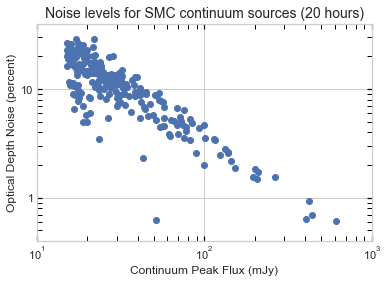

In [12]:
sns.set_context("talk")
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1,1) #, figsize=(6.4, 4.8))
ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_yscale('log', basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_yticklabels(labels=['', '', '1', '10'])
ax.scatter(spec_tab['flux_peak'], spec_tab['sd_cont']*100)
ax.set_xlabel('Continuum Peak Flux (mJy)', size=12)
ax.set_ylabel('Optical Depth Noise (percent)', size=12)
ax.set_xlim(10, 1000)
ax.set_ylim(0.4, 40)
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='black', length=5)
ax.set_title('Noise levels for SMC continuum sources (20 hours)', size=14)
fig.savefig('figures/flux-noise.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/flux-noise.pdf', bbox_inches='tight')

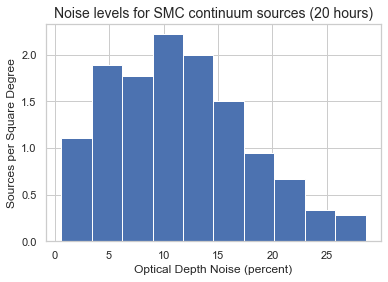

In [13]:
#sns.histplot(data=spec_tab['sd_cont'], weights = np.ones(len(spec_tab))*1/18)
fig, ax = plt.subplots(1,1) #, figsize=(6.4, 4.8))

ax.hist(spec_tab['sd_cont']*100, bins=10, weights=np.ones(len(spec_tab))*1/18)
ax.set_xlabel('Optical Depth Noise (percent)', size=12)
ax.set_ylabel('Sources per Square Degree', size=12)
ax.set_title('Noise levels for SMC continuum sources (20 hours)', size=14)

plt.show()
#fig.savefig('figures/noise-src-count.png', bbox_inches='tight', dpi=200)
#fig.savefig('figures/noise-src-count.pdf', bbox_inches='tight')


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_27545/1016386632.py:5: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_27545/1016386632.py:5: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_27545/1016386632.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['', '', '1', '10'])


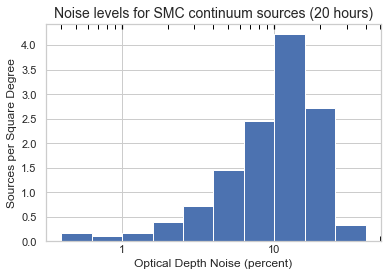

In [14]:
fig, ax = plt.subplots(1,1) #, figsize=(6.4, 4.8))

logbins = np.logspace(np.log10(0.4),np.log10(40),11)
ax.hist(spec_tab['sd_cont']*100, bins=logbins, weights=np.ones(len(spec_tab))*1/18)
ax.set_xscale('log', basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])

ax.set_xticklabels(labels=['', '', '1', '10'])
ax.tick_params(axis='x', which='both', direction='in', bottom=True, top=True, color='black', length=5)
ax.set_xlabel('Optical Depth Noise (percent)', size=12)
ax.set_ylabel('Sources per Square Degree', size=12)
ax.set_title('Noise levels for SMC continuum sources (20 hours)', size=14)


fig.savefig('figures/noise-src-count.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/noise-src-count.pdf', bbox_inches='tight')



### CDF of detections and non-detections

In [15]:
df = spec_tab.to_pandas()

In [16]:
df

,id,comp_name,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,...,e_r_hi_high,e_r_hi_low,f_int,mean_ts,e_mean_ts_high,e_mean_ts_low,ew,e_ew_high,e_ew_low,num_chan
0,1,J004725-712727,11.855960,-71.457707,303.388557,-45.666985,B,15.015000,16.122000,0.000158,...,0.038809,0.029895,1.102875,49.301006,16.704119,9.680266,7.738243,2.237424,1.612089,40.0
1,5,J002620-743741,6.586833,-74.628167,305.179339,-42.390419,C,15.201000,17.952999,0.000142,...,0.051463,0.040763,1.109493,131.917457,76.039480,36.606897,13.045630,4.167123,2.948304,75.0
2,9,J011635-712604,19.148794,-71.434582,300.076822,-45.553951,C,15.333000,16.061001,0.000126,...,0.050155,0.035779,1.068096,146.434269,232.075193,66.822002,6.943311,3.346123,2.454014,85.0
3,10,J010425-742733,16.106350,-74.459193,301.749927,-42.639239,C,15.436000,16.305000,0.000114,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0
4,13,J005535-723533,13.899411,-72.592574,302.495511,-44.532152,C,15.053000,31.764000,0.000085,...,0.053622,0.040285,1.176807,514.518766,223.184919,120.430792,15.776229,3.939496,2.741080,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,367,J005732-741243,14.384618,-74.212140,302.365433,-42.909400,A,439.358002,475.605011,0.003553,...,0.007784,0.007901,0.997023,250.549602,19.845781,18.575508,1.316553,0.058953,0.058586,48.0
225,368,J011050-731426,17.709450,-73.240658,300.995766,-43.814588,A,51.610001,160.432999,0.001398,...,0.001761,0.001646,1.094771,413.871039,7.148224,7.568825,7.675289,0.096567,0.095681,96.0
226,369,J011056-731407,17.735087,-73.235373,300.984810,-43.819071,A,100.070999,199.626007,0.000631,...,0.003928,0.003921,1.094975,349.212607,15.993220,14.082509,8.971799,0.317321,0.311763,97.0
227,370,J011049-731428,17.706215,-73.241230,300.997135,-43.814117,A,404.013000,456.187988,0.004489,...,0.001713,0.001801,1.096328,409.343627,7.299650,7.397183,7.749593,0.097579,0.096917,95.0


In [17]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
sns.set(style="darkgrid")
sns.set_context('paper')

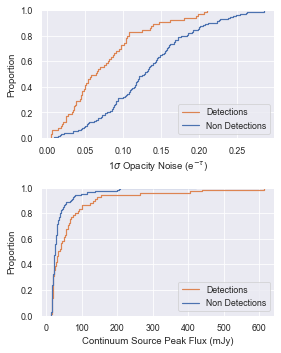

In [18]:
from matplotlib.legend import Legend

#fig, ax = plt.subplots(figsize=(6,4))
fig, ax = plt.subplots(2,1, figsize=(4,5))

ecdf = sns.ecdfplot(data=df, x="sd_cont", hue='has_other_abs', ax=ax[0], legend=False)
ax[0].set_xlabel(r'1$\sigma$ Opacity Noise (e$^{-\tau}$)')
ax[0].legend(['Detections', 'Non Detections'], loc='lower right')


sns.ecdfplot(data=df, x="flux_peak", hue='has_other_abs', ax=ax[1], legend=False)
ax[1].set_xlabel(r'Continuum Source Peak Flux (mJy)')
ax[1].legend(['Detections', 'Non Detections'])

fig.tight_layout()

plt.savefig('figures/spectra_by_peak_flux.png', bbox_inches='tight', dpi=200)

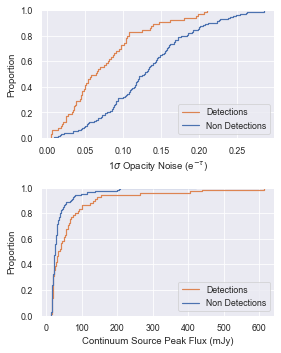

In [19]:
from matplotlib.legend import Legend

#fig, ax = plt.subplots(figsize=(6,4))
fig, ax = plt.subplots(2,1, figsize=(4,5))

ecdf = sns.ecdfplot(data=df, x="sd_cont", hue='has_other_abs', ax=ax[0], legend=False)
ax[0].set_xlabel(r'1$\sigma$ Opacity Noise (e$^{-\tau}$)')
ax[0].legend(['Detections', 'Non Detections'], loc='lower right')


sns.ecdfplot(data=df, x="flux_peak", hue='has_other_abs', ax=ax[1], legend=False)
ax[1].set_xlabel(r'Continuum Source Peak Flux (mJy)')
ax[1].legend(['Detections', 'Non Detections'])

fig.tight_layout()



/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


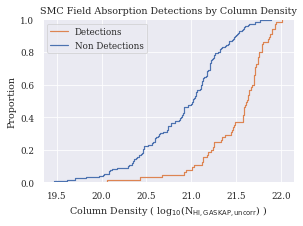

In [20]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
fig, ax = plt.subplots(1,1, figsize=(4.5,3))

df['log_uncorr'] = np.log10(df['nh_uncorr'])
ecdf = sns.ecdfplot(data=df, x="log_uncorr", hue='has_other_abs', ax=ax, legend=False)
ax.set_xlabel(r'Column Density ( log$_{10}$(N$_{\rm HI,GASKAP,uncorr}$) )')
plt.legend(['Detections', 'Non Detections'])
plt.savefig('figures/column_density.pdf', bbox_inches='tight')

ax.set_title('SMC Field Absorption Detections by Column Density')
plt.savefig('figures/column_density_all.png', bbox_inches='tight', dpi=200)

/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


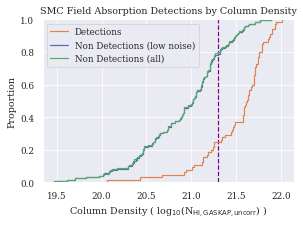

In [21]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
fig, ax = plt.subplots(1,1, figsize=(4.5,3))

df['log_uncorr'] = np.log10(df['nh_uncorr'])
ecdf = sns.ecdfplot(data=df[df['sd_cont'] < 0.25], x="log_uncorr", hue='has_other_abs', ax=ax, legend=False)
sns.ecdfplot(data=df[df['has_other_abs']==False], x="log_uncorr", ax=ax, legend=False, c=sns.color_palette()[2])
ax.set_xlabel(r'Column Density ( log$_{10}$(N$_{\rm HI,GASKAP,uncorr}$) )')
plt.legend(['Detections', 'Non Detections (low noise)', 'Non Detections (all)'])
plt.savefig('figures/column_density.pdf', bbox_inches='tight')
ax.vlines(np.log10(2e21), 0, 1, colors='purple', ls='--', zorder=1)

ax.set_title('SMC Field Absorption Detections by Column Density')
plt.savefig('figures/column_density_diagnostic.png', bbox_inches='tight', dpi=200)

/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


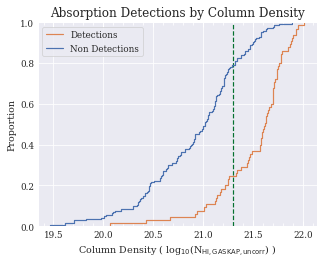

In [22]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
#fig, ax = plt.subplots(1,1, figsize=(4.5,3))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))

df['log_uncorr'] = np.log10(df['nh_uncorr'])
ecdf = sns.ecdfplot(data=df[df['sd_cont'] < 0.25], x="log_uncorr", hue='has_other_abs', ax=ax, legend=False)
ax.set_xlabel(r'Column Density ( log$_{10}$(N$_{\rm HI,GASKAP,uncorr}$) )')
ax.vlines(np.log10(2e21), 0, 1, colors=sns.color_palette('Greens_r')[0], ls='--', zorder=1)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', direction='in', bottom=True, top=True, color='w')
ax.set_title('Absorption Detections by Column Density', size=12)


plt.legend(['Detections', 'Non Detections'])
plt.savefig('figures/column_density.pdf', bbox_inches='tight')

plt.savefig('figures/column_density.png', bbox_inches='tight', dpi=200)

/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_27545/1375273579.py:11: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_27545/1375273579.py:11: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])


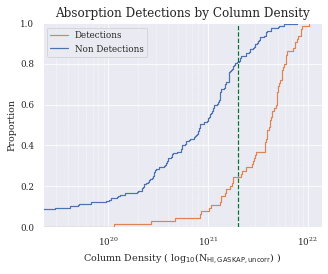

In [23]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
#fig, ax = plt.subplots(1,1, figsize=(4.5,3))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))

df['log_uncorr'] = np.log10(df['nh_uncorr'])
ecdf = sns.ecdfplot(data=df[df['sd_cont'] < 0.25], x="nh_uncorr", hue='has_other_abs', ax=ax, legend=False)
ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlabel(r'Column Density ( log$_{10}$(N$_{\rm HI,GASKAP,uncorr}$) )')
#ax.vlines(np.log10(2e21), 0, 1, colors=sns.color_palette('Greens_r')[0], ls='--', zorder=1)
ax.vlines(2e21, 0, 1, colors=sns.color_palette('Greens_r')[0], ls='--', zorder=1)

plt.grid(True, which="major", ls="-")
plt.grid(True, which="minor", ls=":")


#ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.tick_params(which='both', direction='in', bottom=True, top=True, color='w')
ax.set_title('Absorption Detections by Column Density', size=12)

plt.legend(['Detections', 'Non Detections'])
plt.savefig('figures/column_density_log.pdf', bbox_inches='tight')

/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_27545/1174776507.py:30: UserWarning: The handle <matplotlib.collections.LineCollection object at 0x7fbd246d2ac0> has a label of '_hidden' which cannot be automatically added to the legend.
  plt.legend(['_hidden', 'Detections', 'Non Detections'])


(0.0, 23.1)


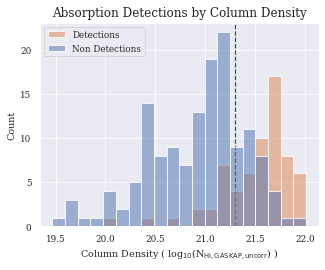

In [24]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
#fig, ax = plt.subplots(1,1, figsize=(4.5,3))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))

df['log_uncorr'] = np.log10(df['nh_uncorr'])
#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])

ecdf = sns.histplot(data=df[(df['sd_cont'] < 0.25) & (df['log_uncorr'] > 0)], x="log_uncorr", hue='has_other_abs', ax=ax, 
                    legend=False, bins=20)
#ecdf = sns.kdeplot(data=df[df['sd_cont'] < 0.25], x="nh_uncorr", hue='has_other_abs', ax=ax, legend=False, multiple="stack")
#ecdf = sns.kdeplot(data=df[df['sd_cont'] < 0.25], x="nh_uncorr", hue='has_other_abs', ax=ax, legend=False, multiple="stack")
print (ax.get_ylim())
curr_ylim = ax.get_ylim()
#ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlabel(r'Column Density ( log$_{10}$(N$_{\rm HI,GASKAP,uncorr}$) )')
ax.vlines(np.log10(2e21), 0, curr_ylim[1], colors=sns.color_palette('Greens_r')[0], ls='--', zorder=1)
ax.set_ylim(curr_ylim)
plt.grid(True, which="major", ls="-")
plt.grid(True, which="minor", ls=":")


#ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.tick_params(which='both', direction='in', bottom=True, top=True, color='w')
ax.set_title('Absorption Detections by Column Density', size=12)

plt.legend(['_hidden', 'Detections', 'Non Detections'])
plt.savefig('figures/column_density_log_hist.pdf', bbox_inches='tight')

In [25]:
noise_filt = df['sd_cont'] < 0.25
print (len(df[noise_filt]), np.sum(df[noise_filt]['has_other_abs']))

222 65


### Filter absorption in noisy spectra which were later excluded

In later analysis of the SMC spectra, a more rigorous criteria was used for the inclusion of spctra in the dataset:

* continuum noise <= 0.3
* beam_power >= 0.8

Before further analysis of absorption, the set needs to be trimmed down to match the spectra

In [26]:
abs_tab = parse_single_table('sb10944/v3b/askap_absorption.vot').to_table()

retained = np.isin(abs_tab['comp_name'], spec_tab['comp_name'])

print ("Of {} features, {} are retained.".format(len(abs_tab), np.sum(retained)))

abs_tab_trimmed = abs_tab[retained]

filename = 'gaskap_smc_absorption.vot'
abs_tab_trimmed.write(filename, table_id='gaskap_smc_absorption', format='votable', overwrite=True)
print ('Wrote trimmed absoprtion table to', filename)


abs_tab[~retained]

Of 134 features, 130 are retained.
Wrote trimmed absoprtion table to gaskap_smc_absorption.vot


id,comp_name,abs_name,ra,dec,rating,flux_peak,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,semi_maj_axis,semi_min_axis,pa,start_vel,end_vel,length,min_optical_depth,e_min_optical_depth,peak_tau,e_peak_tau,max_sigma,ew,e_ew
,,,deg,deg,,mJy / beam,mJy / beam,,,,,,arcsec,arcsec,deg,km / s,km / s,chan,,,,,,km / s,km / s
int64,str32,str32,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
129,J014637-724855,J014637-724855_14,26.654795,-72.815511,B,16.833999633789062,4.378987941890955e-05,0.20003482622953167,1.386617660522461,1.6085959898399291,1.5315570831298828,70.0,8.687999725341797,7.776000213623047,148.17999267578125,14.347926565939416,15.347926565913717,2,0.189072385430336,0.2047678090496319,1.6656253337860107,0.7338152840582061,3.9602300441387808,2.7974486763269373,0.3263008209785595
313,J002906-735349,J002906-735349_101,7.278655,-73.89707,A,91.98200225830078,0.000787205621600151,0.04545207737999783,0.9496815800666809,4.27475271616603,1.1800428628921509,118.0,3.7919998168945312,3.284000015258789,133.7899932861328,101.630649723504,108.630649723791,8,0.23036128282546997,0.06022470368232596,1.4681063890457153,0.23225063742103202,12.779452120416071,4.67204059195939,0.17411752732371708
352,J002411-735717,J002411-735717_97,6.047734,-73.954946,B,123.6449966430664,0.0007319849915802479,0.03682886412704189,0.3851681351661682,1.5645860419633262,1.1501872539520264,113.0,5.395999908447266,3.379999923706055,127.77999877929688,97.73889931384,98.738899313881,2,0.7650191187858582,0.043599872429329056,0.2678544521331787,0.05542701662060079,5.389485521890503,0.4140545986379387,0.06268313054312104
356,J002143-741500,J002143-741500_123,5.43182,-74.250046,B,145.00799560546875,0.001453503407537937,0.04561975225886483,0.4490877389907837,1.6074107860325177,1.172235131263733,97.0,3.743999862670899,3.2360000610351562,137.64999389648438,123.920594745406,125.92059474548796,3,0.7231473922729492,0.05564614204300729,0.3241422176361084,0.07413291000655753,5.033043200585425,0.8271545008896212,0.09857135590000997


### Plot of SMC absorption features by optical depth

In [2]:
abs_tab = parse_single_table('gaskap_smc_absorption.vot').to_table()
smc_abs_tab = abs_tab[abs_tab['start_vel']> 50]

In [3]:
abs_df = abs_tab.to_pandas()
smc_abs_df = smc_abs_tab.to_pandas()
smc_abs_df

,id,comp_name,abs_name,ra,dec,rating,flux_peak,mean_cont,sd_cont,opacity_range,...,semi_min_axis,pa,start_vel,end_vel,length,min_optical_depth,e_min_optical_depth,peak_tau,e_peak_tau,max_sigma
0,13,J005535-723533,J005535-723533_113,13.899411,-72.592574,C,15.053000,0.000085,0.162273,1.856299,...,4.432,140.710007,113.615978,114.615978,2,-0.332693,0.251391,5.000000,3.619253,5.301279
1,13,J005535-723533,J005535-723533_116,13.899411,-72.592574,C,15.053000,0.000085,0.162273,1.856299,...,4.432,140.710007,116.615978,117.615978,2,-0.067383,0.270182,5.000000,3.691341,3.950607
2,19,J005448-725353,J005448-725353_116,13.702572,-72.898137,C,15.988000,0.000155,0.180708,2.211228,...,3.268,137.130005,116.777136,118.777136,3,-0.122017,0.310779,5.000000,3.831327,3.610335
3,19,J005448-725353,J005448-725353_163,13.702572,-72.898137,C,15.988000,0.000155,0.180708,2.211228,...,3.268,137.130005,163.777136,167.777136,5,-0.476034,0.307786,5.000000,3.821651,4.795642
4,26,J010532-721331,J010532-721331_131,16.386939,-72.225495,C,16.306000,0.000134,0.206259,1.732353,...,3.228,138.699997,131.318491,133.318491,3,-0.032339,0.244997,5.000000,3.593490,4.213683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,370,J011049-731428,J011049-731428_135,17.706215,-73.241230,A,404.013000,0.004489,0.006336,0.498258,...,3.368,132.330002,135.777646,148.777646,14,0.831592,0.008249,0.184414,0.009871,20.415632
115,370,J011049-731428,J011049-731428_150,17.706215,-73.241230,A,404.013000,0.004489,0.006336,0.498258,...,3.368,132.330002,150.777646,168.777646,19,0.540591,0.009988,0.615092,0.018307,45.997348
116,370,J011049-731428,J011049-731428_172,17.706215,-73.241230,A,404.013000,0.004489,0.006336,0.498258,...,3.368,132.330002,172.777646,175.777646,4,0.949157,0.009357,0.052181,0.009810,5.433862
117,370,J011049-731428,J011049-731428_177,17.706215,-73.241230,A,404.013000,0.004489,0.006336,0.498258,...,3.368,132.330002,177.777646,178.777646,2,0.958851,0.008615,0.042020,0.008945,4.776406


In [4]:
min_opacity = np.maximum(smc_abs_tab['sd_cont'], smc_abs_tab['min_optical_depth'])

In [5]:
#num_samples = 40 # -100 to -60
capped_min_od = min_opacity
capped_min_od[capped_min_od < 0] = 0
tau = -1* np.log(capped_min_od)
tau[capped_min_od==0] = 5
tau_nan = np.nan_to_num(tau, nan=5)
min_od_noise = capped_min_od-smc_abs_tab['sd_cont']
filt = min_od_noise < 0
min_od_noise[filt] = capped_min_od[filt]+smc_abs_tab['sd_cont'][filt]
tau_nan_max = -1* np.log(min_od_noise)
tau_uncert = np.abs(smc_abs_tab['sd_cont'] / capped_min_od)
tau_uncert_calc = np.abs(tau_nan_max - tau_nan)
tau_uncert_plus = np.abs(tau_nan_max - tau_nan)
tau_uncert_minus = np.abs(tau_nan_max - tau_nan)
tau_uncert_calc

#tau_uncert
for idx, e_tau in enumerate(tau_uncert):
    if tau_nan[idx] > 2 and min_opacity[idx] > 0:
        print ("od={:.3f} +- {:.3f} tau={:.2f} +- {:.2f} or {:.2f}".format(
            min_opacity[idx], smc_abs_tab['sd_cont'][idx], tau_nan[idx], e_tau, tau_uncert_calc[idx]))

od=0.078 +- 0.078 tau=2.55 +- 1.00 or --
od=0.085 +- 0.085 tau=2.47 +- 1.00 or --
od=0.082 +- 0.082 tau=2.50 +- 1.00 or --
od=0.132 +- 0.105 tau=2.03 +- 0.80 or 1.59
od=0.105 +- 0.105 tau=2.26 +- 1.00 or --
od=0.125 +- 0.125 tau=2.08 +- 1.00 or --
od=0.087 +- 0.087 tau=2.44 +- 1.00 or --
od=0.068 +- 0.068 tau=2.69 +- 1.00 or --
od=0.066 +- 0.066 tau=2.72 +- 1.00 or --
od=0.070 +- 0.070 tau=2.66 +- 1.00 or --
od=0.078 +- 0.055 tau=2.55 +- 0.70 or 1.22
od=0.051 +- 0.051 tau=2.98 +- 1.00 or --
od=0.047 +- 0.047 tau=3.06 +- 1.00 or --
od=0.039 +- 0.035 tau=3.26 +- 0.92 or 2.48
od=0.025 +- 0.025 tau=3.70 +- 1.00 or --
od=0.022 +- 0.022 tau=3.82 +- 1.00 or --


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_35710/84489711.py:10: RuntimeWarning: divide by zero encountered in log
  tau_nan_max = -1* np.log(min_od_noise)
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_35710/84489711.py:20: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  print ("od={:.3f} +- {:.3f} tau={:.2f} +- {:.2f} or {:.2f}".format(


In [6]:
tau_uncert_calc = np.vstack([tau_uncert_plus.data, tau_uncert_minus.data])
print (tau_uncert_calc.shape, tau_uncert_calc)

(2, 119) [[1.         1.         1.         1.         1.         1.
  0.17736063 1.47149291 0.18299948 0.20939231 0.1917752  0.63714873
  1.         1.         1.         0.98905997 0.17578085 0.22418759
  1.         1.         0.15355779 1.         0.26866676 0.08963402
  0.07606271 0.12522418 0.08823671 0.07452414 0.07630159 0.07437167
  0.17893746 1.59126945 0.23393516 0.25258011 0.52934225 0.77872765
  0.1942038  0.56209026 0.3238653  0.10537017 1.         0.41150533
  1.         0.19002858 1.         0.19568594 0.22572121 0.19040628
  0.18701761 0.04251918 0.16316764 0.1135377  1.         0.20430634
  0.09830525 1.         1.         0.09376994 0.21509272 0.08972053
  0.0542412  0.52646719 0.06568075 0.0728092  0.06376186 0.06446283
  0.07985471 1.21521462 0.06970043 0.12219942 0.15547517 0.04652761
  0.09640354 0.11063365 0.08922457 1.         0.07522964 0.08924642
  0.06761669 0.06611758 0.07533255 1.         0.06679331 0.08162684
  0.04904158 0.07176635 0.06327043 0.0668311  0

/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_35710/2752494472.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(-1* np.log(noise_range), noise_range)


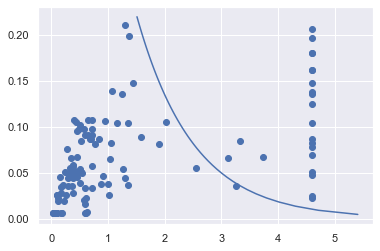

In [7]:
min_opacity = np.maximum(0.01, smc_abs_tab['min_optical_depth'])
tau = -1* np.log(min_opacity)
plt.scatter(tau, smc_abs_tab['sd_cont'])
noise_range = np.linspace(0, 0.22)
plt.plot(-1* np.log(noise_range), noise_range)

In [12]:
non_smc_body_abs = np.asarray(spec_tab['comp_name'][spec_tab['has_other_abs'] & (spec_tab['nh_uncorr'] < 2e21)])
non_smc_body_abs

array(['J013134-700042', 'J012924-733153', 'J013218-715348',
       'J003037-742903', 'J003037-742901', 'J003414-733329',
       'J011134-711414', 'J003242-733153', 'J012349-735039',
       'J005715-704046', 'J005652-712300', 'J013704-730413',
       'J013701-730415', 'J010930-713456', 'J005732-741243',
       'J005611-710707'], dtype='<U32')

/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_35710/2125157555.py:44: RuntimeWarning: divide by zero encountered in log
  ax.plot(-1* np.log(noise_range), noise_range, color=sns.color_palette()[2], label="Noise limit")


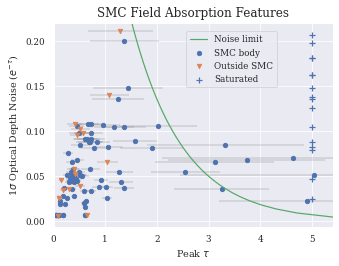

In [13]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

#fig, ax = plt.subplots(1,1, figsize=(4.5,3))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))


e_tau = smc_abs_tab['e_peak_tau']

min_opacity = np.asarray(smc_abs_tab['min_optical_depth'])
opacity_filter = min_opacity > 0
tau = smc_abs_tab['peak_tau'][opacity_filter]

noise = smc_abs_tab['sd_cont'][opacity_filter]
e_tau_non_sat = e_tau[opacity_filter]
non_smc_body_filter = np.isin(smc_abs_tab['comp_name'][opacity_filter], non_smc_body_abs)



plt.errorbar(tau[~non_smc_body_filter], noise[~non_smc_body_filter], xerr=e_tau_non_sat[~non_smc_body_filter], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(tau[~non_smc_body_filter], noise[~non_smc_body_filter], c='C0', s=20, label="SMC body")


plt.errorbar(tau[non_smc_body_filter], noise[non_smc_body_filter], xerr=e_tau_non_sat[non_smc_body_filter], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(tau[non_smc_body_filter], noise[non_smc_body_filter], color=sns.color_palette()[1], marker='v', s=20, label="Outside SMC")


full_non_smc_body_filter = np.isin(smc_abs_tab['comp_name'], non_smc_body_abs)
filt = ~opacity_filter & full_non_smc_body_filter
saturated = np.ones((np.sum(filt)))*5
ax.scatter(saturated, smc_abs_tab['sd_cont'][filt], color=sns.color_palette()[1], marker='+', s=40)
#plt.errorbar(saturated, smc_abs_tab['sd_cont'][filt], xerr=e_tau[filt], color=sns.color_palette()[1], fmt="+", alpha=0.6, ls=':')

filt = ~opacity_filter & ~full_non_smc_body_filter
saturated = np.ones((np.sum(filt)))*5
ax.scatter(saturated, smc_abs_tab['sd_cont'][filt], color=sns.color_palette()[0], marker='+', s=40, label="Saturated")
#plt.errorbar(saturated, smc_abs_tab['sd_cont'][filt], xerr=e_tau[filt], color=sns.color_palette()[0], fmt="+", alpha=0.6, ls=':')


noise_range = np.linspace(0, 0.22)
ax.plot(-1* np.log(noise_range), noise_range, color=sns.color_palette()[2], label="Noise limit")
ax.set_xlabel(r'Peak $\tau$')
ax.set_ylabel(r'1$\sigma$ Optical Depth Noise ($e^{-\tau}$)')
ax.set_xlim(0,5.4)
ax.set_ylim(-0.006,0.22)


ax.legend(loc='upper left', bbox_to_anchor=(0.46, 0.98))
#ax.legend(loc='upper right')
ax.set_title('SMC Field Absorption Features', size=12)


plt.savefig('figures/optical_depth_old.pdf', bbox_inches='tight')

plt.savefig('figures/optical_depth_old.png', bbox_inches='tight', dpi=200)




/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_35710/2565281043.py:44: RuntimeWarning: divide by zero encountered in log
  ax.plot(noise_range, -1* np.log(noise_range), color=sns.color_palette()[2], label="Noise limit")


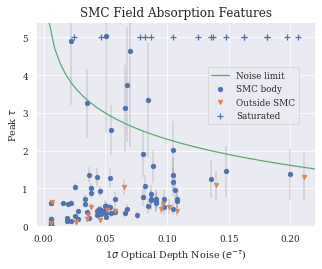

In [25]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

#fig, ax = plt.subplots(1,1, figsize=(4.5,3))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))


e_tau = smc_abs_tab['e_peak_tau']

min_opacity = np.asarray(smc_abs_tab['min_optical_depth'])
opacity_filter = min_opacity > 0
tau = smc_abs_tab['peak_tau'][opacity_filter]

noise = smc_abs_tab['sd_cont'][opacity_filter]
e_tau_non_sat = e_tau[opacity_filter]
non_smc_body_filter = np.isin(smc_abs_tab['comp_name'][opacity_filter], non_smc_body_abs)



plt.errorbar(noise[~non_smc_body_filter], tau[~non_smc_body_filter], yerr=e_tau_non_sat[~non_smc_body_filter], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(noise[~non_smc_body_filter], tau[~non_smc_body_filter], c='C0', s=20, label="SMC body")


plt.errorbar(noise[non_smc_body_filter], tau[non_smc_body_filter], yerr=e_tau_non_sat[non_smc_body_filter], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(noise[non_smc_body_filter], tau[non_smc_body_filter], color=sns.color_palette()[1], marker='v', s=20, label="Outside SMC")


full_non_smc_body_filter = np.isin(smc_abs_tab['comp_name'], non_smc_body_abs)
filt = ~opacity_filter & full_non_smc_body_filter
saturated = np.ones((np.sum(filt)))*5
ax.scatter(smc_abs_tab['sd_cont'][filt], saturated, color=sns.color_palette()[1], marker='+', s=40)
#plt.errorbar(saturated, smc_abs_tab['sd_cont'][filt], xerr=e_tau[filt], color=sns.color_palette()[1], fmt="+", alpha=0.6, ls=':')

filt = ~opacity_filter & ~full_non_smc_body_filter
saturated = np.ones((np.sum(filt)))*5
ax.scatter(smc_abs_tab['sd_cont'][filt], saturated, color=sns.color_palette()[0], marker='+', s=40, label="Saturated")
#plt.errorbar(saturated, smc_abs_tab['sd_cont'][filt], xerr=e_tau[filt], color=sns.color_palette()[0], fmt="+", alpha=0.6, ls=':')


noise_range = np.linspace(0, 0.22)
ax.plot(noise_range, -1* np.log(noise_range), color=sns.color_palette()[2], label="Noise limit")
ax.set_ylabel(r'Peak $\tau$')
ax.set_xlabel(r'1$\sigma$ Optical Depth Noise ($e^{-\tau}$)')
ax.set_ylim(0,5.4)
ax.set_xlim(-0.006,0.22)


ax.legend(loc='upper left', bbox_to_anchor=(0.6, 0.8))
#ax.legend(loc='upper right')
ax.set_title('SMC Field Absorption Features', size=12)


plt.savefig('figures/optical_depth.pdf', bbox_inches='tight')

plt.savefig('figures/optical_depth.png', bbox_inches='tight', dpi=200)





In [27]:
in_noise_filter = (smc_abs_tab['min_optical_depth'] < smc_abs_tab['sd_cont']) & opacity_filter
num_in_noise = np.sum(in_noise_filter)
smc_good_tau = -1* np.log(min_opacity[~in_noise_filter &opacity_filter])
#smc_abs_tab['min_opacity'][~in_noise_filter & opacity_filter]
med_tau = np.median(smc_good_tau)
print ("Num features {} num saturated {} num in the noise {} median tau for reliable {:.2f}".format(len(smc_abs_tab), np.sum(~opacity_filter), num_in_noise, med_tau))
print ("Of the {} good tau, min {:.2f}, med {:.2f} max {:.2f}".format(len(smc_good_tau), np.min(smc_good_tau), np.median(smc_good_tau), np.max(smc_good_tau)))

Num features 119 num saturated 16 num in the noise 6 median tau for reliable 0.50
Of the 97 good tau, min 0.04, med 0.50 max 3.26


In [28]:
non_smc_body_tau = -1* np.log(min_opacity[~in_noise_filter &opacity_filter & full_non_smc_body_filter])
print ("Of the {} non SMC body tau, min {:.2f}, med {:.2f} max {:.2f}".format(
    len(non_smc_body_tau), np.min(non_smc_body_tau), np.median(non_smc_body_tau), np.max(non_smc_body_tau)))

Of the 17 non SMC body tau, min 0.09, med 0.42 max 1.30


In [29]:
smc_body_tau = -1* np.log(min_opacity[~in_noise_filter &opacity_filter & ~full_non_smc_body_filter])
print ("Of the {} SMC body tau, min {:.2f}, med {:.2f} max {:.2f}".format(
    len(smc_body_tau), np.min(smc_body_tau), np.median(smc_body_tau), np.max(smc_body_tau)))

Of the 80 SMC body tau, min 0.04, med 0.52 max 3.26


In [36]:
prev_cap = 0
print ('min  max num det   pct')
for cap in [30, 50, 10000]:
    src_filter = (spec_tab['flux_peak'] >= prev_cap) & (spec_tab['flux_peak'] < cap) & (spec_tab['nh_uncorr'] >= 2e21)
    num_spec = np.sum(src_filter)
    num_det = np.sum(spec_tab['has_other_abs'][src_filter])
    print ("{:2.0f} {:5d} {:3d} {:3d} {:.1f}%".format(prev_cap, cap, num_spec, num_det, num_det/num_spec*100))
    prev_cap = cap

min  max num det   pct
 0    30  49  22 44.9%
30    50  11   8 72.7%
50 10000  19  19 100.0%


In [37]:
df1 = smc_abs_df.groupby('comp_name')['abs_name'].agg(['count']).reset_index()
df1.sort_values('comp_name')

,comp_name,count
0,J003037-742901,1
1,J003037-742903,1
2,J003242-733153,1
3,J003414-733329,1
4,J003809-735024,2
...,...,...
60,J012924-733153,1
61,J013134-700042,1
62,J013218-715348,1
63,J013701-730415,1


In [38]:
print ("Of {} spectra, {} have multiple features".format(len(df1), np.sum(df1['count'] > 1)))

Of 65 spectra, 36 have multiple features


In [39]:
df2 = df1[np.isin(df1['comp_name'], non_smc_body_abs)]
print ("Of {} spectra, {} have multiple features".format(len(df2), np.sum(df2['count'] > 1)))

Of 16 spectra, 1 have multiple features


In [ ]:
df2

### Comparison of detections with noise and flux

In [ ]:

sns.displot(data=pd, x="flux_peak", y="sd_cont", hue='has_other_abs', log_scale=True)

In [ ]:

#fig, ax = plt.subplots(figsize=(6,4))
fig, ax = plt.subplots(2,1, figsize=(4,5), sharex=True)
ecdf = sns.ecdfplot(data=pd[pd['n_h'] < 2e21], x="sd_cont", hue='has_other_abs', ax=ax[0], legend=False)
ax[0].set_ylabel(r'Non-SMC Proportion')
ax[0].legend(['Detections', 'Non Detections'], loc='lower right')


sns.ecdfplot(data=pd[pd['n_h'] >= 2e21], x="sd_cont", hue='has_other_abs', ax=ax[1], legend=False)
ax[1].set_xlabel(r'1$\sigma$ Opacity Noise (e$^{-\tau}$)')
ax[1].set_ylabel(r'SMC Proportion')
ax[1].legend(['Detections', 'Non Detections'], loc='lower right')

fig.tight_layout()

plt.savefig('figures/spectra_by_od_noise.png', bbox_inches='tight', dpi=200)

In [ ]:

#fig, ax = plt.subplots(figsize=(6,4))
fig, ax = plt.subplots(2,1, figsize=(4,5), sharex=True)
ecdf = sns.ecdfplot(data=pd[pd['n_h'] < 2e21], x="flux_peak", hue='has_other_abs', ax=ax[0],)
ax[0].set_ylabel(r'Non-SMC Proportion')
ax[0].legend(['Detections', 'Non Detections'], loc='lower right')

sns.ecdfplot(data=pd[pd['n_h'] >= 2e21], x="flux_peak", hue='has_other_abs', ax=ax[1], )
ax[1].set_xlabel(r'Continuum Source Peak Flux (mJy)')
ax[1].set_ylabel(r'SMC Proportion')
ax[1].legend(['Detections', 'Non Detections'], loc='lower right')

fig.tight_layout()

plt.savefig('figures/spectra_by_peak_flux.png', bbox_inches='tight', dpi=200)

In [ ]:

#fig, ax = plt.subplots(figsize=(6,4))
fig, ax = plt.subplots(2,1, figsize=(4,5), sharex=True)
ecdf = sns.histplot(data=pd[pd['n_h'] < 2e21], x="sd_cont", hue='has_other_abs', ax=ax[0])
#ax[0].set_ylabel()
#ax[0].set_xlabel(r'1$\sigma$ Opacity Noise (e$^{-\tau}$)')

#leg = Legend(ax, lines[2:], ['line C', 'line D'],
#             loc='lower right', frameon=False)
#ax[0].add_artist(leg);
#ax[0].set_xlim((0, 1.4))



sns.histplot(data=pd[pd['n_h'] >= 2e21], x="sd_cont", hue='has_other_abs', ax=ax[1])

#sns.ecdfplot(data=pd, x="flux_peak", hue='has_other_abs', ax=ax[1])
ax[1].set_xlabel(r'1$\sigma$ Opacity Noise (e$^{-\tau}$)')
#ax[1].set_xlim((0, 1.4))
#ax[1].set_xlabel(r'Continuum Source Peak Flux (mJy)')


fig.tight_layout()

In [ ]:

#fig, ax = plt.subplots(figsize=(6,4))
fig, ax = plt.subplots(2,1, figsize=(4,5), sharex=True)
ecdf = sns.ecdfplot(data=pd[pd['n_h'] < 2e21], x="flux_peak", hue='has_other_abs', ax=ax[0],)
#ax[0].set_ylabel()
#ax[0].set_xlabel(r'1$\sigma$ Opacity Noise (e$^{-\tau}$)')

#leg = Legend(ax, lines[2:], ['line C', 'line D'],
#             loc='lower right', frameon=False)
#ax[0].add_artist(leg);
#x[0].set_xlim((0, 1.4))



sns.ecdfplot(data=pd[pd['n_h'] >= 2e21], x="flux_peak", hue='has_other_abs', ax=ax[1], )

#sns.ecdfplot(data=pd, x="flux_peak", hue='has_other_abs', ax=ax[1])
ax[1].set_xlabel(r'Continuum Source Peak Flux (mJy)')
#ax[1].set_xlim((0, 1.4))
#ax[1].set_xlabel(r'Continuum Source Peak Flux (mJy)')



fig.tight_layout()

In [ ]:
sub_pd = pd[pd["min_opacity"] > 0]
g = sns.displot(data=sub_pd, x=-1*np.log(sub_pd["min_opacity"]), y="sd_cont", kind="kde", rug=True, shade=True, )
g.set_axis_labels(r"Optical Depth ($\tau$)", r"1$\sigma$ Optical Depth Noise")

In [ ]:
tau_grid = pd[pd["min_opacity"] > 0].pivot("sd_cont", "min_opacity")
sns.heatmap(tau_grid)
#sns.heatmap(data=pd[pd["min_opacity"] > 0], x=-1*np.log(pd["min_opacity"]), y="sd_cont", )

In [ ]:
tau_grid